![](UC_FMRI.jpg)

# Flujo de Trabajo (*Workflow*)

Un flujo de trabajo controla la configuración y la ejecución de interfaces individuales. Supongamos que desea ejecutar múltiples interfaces en un orden específico, donde algunas tienen que esperar a que otras terminen mientras que otras se pueden ejecutar en paralelo. Lo bueno de un flujo de trabajo nipype es que el flujo de trabajo se encargará de la entrada y salida de cada interfaz y organizará la ejecución de cada interfaz de la manera más eficiente.

Por lo tanto, un flujo de trabajo consta de varios nodos , cada uno de los cuales representa una interfaz específica y una conexión dirigida entre esos nodos. Esas conexiones especifican qué salida de qué nodo debe usarse como entrada para otro nodo. Para comprender mejor por qué esto es tan bueno, veamos un ejemplo.

## Librerias

In [1]:
import os # El módulo os nos permite acceder a funcionalidades dependientes del Sistema Operativo
import numpy as np # Librería de Python especializada en el cálculo numérico y el análisis de datos
import matplotlib.pyplot as plt # El módulo pyplot emula el entorno de programación gráfica de MATLAB
import nibabel as nb # Biblioteca para leer y escribir imágenes médicas

# Importar nodo, flujo de trabajo e interfaz FSL
from nipype import Node, Workflow
from nipype.interfaces import fsl

## Definimos funciones

In [2]:
# Let's create a short helper function to plot 3D NIfTI images
'''
Creamos una función auxiliar para seleccionar un corte 
y trazar (mostrar) imágenes 3D NIfTI
'''

def plot_slice(fname):
    # Carga la imagen
    img = nb.load(fname)
    data = img.get_data()

    # Seleccionamos corte en el medio del cerebro
    cut = int(data.shape[-1]/2) + 10

    # Trazamos los datos
    plt.imshow(np.rot90(data[..., cut]), cmap="gray")
    plt.gca().set_axis_off()

## Definimos parametros

In [3]:
# Dirección/ruta de la carpeta donde reposan las imagenes
dir_exp = '/home/aracena/thesis/data/sub001/'

# Nombre de la imagen a procesar
img_ana = 'sub-01_T1w.nii'

# Ruta de la imagen a rocesar
dir_img_ana = os.path.join(dir_exp,img_ana)

# Ruta de la carpeta donde se guarda las imgenes procesadas (debe existir)
dir_res_pro = '/home/aracena/thesis_practica/Tips_nipype/output_worfklow1/'

## Definimos nodos e interfaces


En general, un nodo consta de los siguientes elementos:

    nodename = Nodetype(interface_function(), name='labelname')
 
- nodename : nombre de la variable del nodo en el entorno de Python.
- Nodetype : tipo de nodo a crear. Puede ser un Node, MapNodeo JoinNode.
- interface_function : Función que debe ejecutar el nodo. Puede ser específico del usuario o provenir de un Interface.
- labelname : nombre de etiqueta del nodo en el entorno del flujo de trabajo (define el nombre del directorio de trabajo)

In [4]:
'''
Proceso Skullstrip 
Elimina el cráneo de mri/T1.mgz y almacena el resultado en mri/brainmask.auto.mgz y mri/brainmask.mgz

fsl.BET.help()
'''
skullstrip = Node(fsl.BET(in_file=dir_img_ana, mask=True), name="skullstrip")


'''
Proceso Smooth
Suavizar espacialmente una imagen con un kernel gaussiano.

fsl.IsotropicSmooth.help()
'''
smooth = Node(fsl.IsotropicSmooth(in_file=dir_img_ana, fwhm=4), name="smooth")

'''
proceso Mask
Alicar una máscara binaria a otra imagen

fsl.ApplyMask.help()
'''
mask = Node(fsl.ApplyMask(), name="mask")

## Inicio de un flujo de trabajo

In [5]:
# Initiation of a workflow
wf = Workflow(name="smoothflow", base_dir=dir_res_pro+"working_dir")

## Conectar nodos en el flujo de trabajo

El objeto de flujo de trabajo tiene un método llamado *connect* que va a hacer la mayor parte del trabajo.
Hay dos formas diferentes de llamar *connect*:

    connect(source, "source_output", dest, "dest_input")

    connect([(source, dest, [("source_output1", "dest_input1"),
                         ("source_output2", "dest_input2")
                         ])
         ])
  
Con el primer enfoque, puede establecer una conexión a la vez. Con el segundo puedes establecer múltiples conexiones entre dos nodos a la vez. En cualquier caso, le proporcionará cuatro datos para definir la conexión:

- El objeto del nodo de origen
- El nombre del campo de salida del nodo de origen
- El objeto del nodo de destino
- El nombre del campo de entrada del nodo de destino

In [6]:
# Método "simple", primer enfoque, pero más restringido
wf.connect(skullstrip, "mask_file", mask, "mask_file")

# Segundo enfoque
wf.connect([(smooth, mask, [("out_file", "in_file")])])

¡Ahora el flujo de trabajo está completo!

## Visualización del flujo de trabajo

El flujo de trabajo se puede considerar como un gráfico acíclico dirigido. De hecho, así es literalmente como se representa detrás de escena, y podemos usar eso para explorar el flujo de trabajo visualmente:

211215-18:16:12,777 nipype.workflow INFO:
	 Generated workflow graph: /home/aracena/thesis_practica/Tips_nipype/output_worfklow1/working_dir/smoothflow/workflow_graph.png (graph2use=hierarchical, simple_form=True).


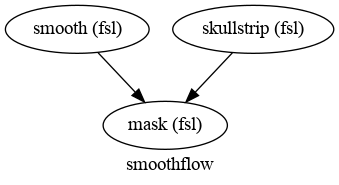

In [7]:
wf.write_graph("workflow_graph.dot")
from IPython.display import Image
Image(filename=dir_res_pro+"working_dir/smoothflow/workflow_graph.png")

Esta representación hace que la estructura de dependencia del flujo de trabajo sea obvia. (Por cierto, los nombres de los nodos en este gráfico son los nombres que le dimos a nuestros objetos Node anteriormente, ¡así que elija algo significativo para ellos!)

Ciertos tipos de gráficos también le permiten inspeccionar más a fondo las conexiones individuales entre los nodos. Por ejemplo:

211215-18:16:14,324 nipype.workflow INFO:
	 Generated workflow graph: /home/aracena/thesis_practica/Tips_nipype/output_worfklow1/working_dir/smoothflow/graph.png (graph2use=flat, simple_form=True).


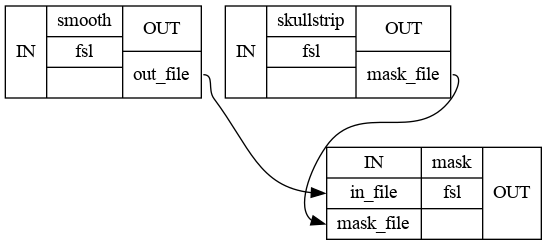

In [8]:
wf.write_graph(graph2use='flat')
from IPython.display import Image
Image(filename=dir_res_pro+"working_dir/smoothflow/graph_detailed.png")

## Corremos el flujo de trabajo

In [9]:
# Especificar el directorio base para el directorio de trabajo
wf.base_dir = dir_res_pro+"working_dir"

# Execute the workflow
wf.run()

211215-18:16:14,345 nipype.workflow INFO:
	 Workflow smoothflow settings: ['check', 'execution', 'logging', 'monitoring']
211215-18:16:14,350 nipype.workflow INFO:
	 Running serially.
211215-18:16:14,350 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.smooth" in "/opt/home/aracena/thesis_practica/Tips_nipype/output_worfklow1/working_dir/smoothflow/smooth".
211215-18:16:14,352 nipype.workflow INFO:
	 [Node] Cached "smoothflow.smooth" - collecting precomputed outputs
211215-18:16:14,354 nipype.workflow INFO:
	 [Node] "smoothflow.smooth" found cached.
211215-18:16:14,354 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.skullstrip" in "/opt/home/aracena/thesis_practica/Tips_nipype/output_worfklow1/working_dir/smoothflow/skullstrip".
211215-18:16:14,358 nipype.workflow INFO:
	 [Node] Cached "smoothflow.skullstrip" - collecting precomputed outputs
211215-18:16:14,358 nipype.workflow INFO:
	 [Node] "smoothflow.skullstrip" found cached.
211215-18:16:14,359 nipype.workflow INFO:
	 [N

La especificación de base_dires muy importante (y es por eso que necesitamos usar rutas absolutas arriba) porque de lo contrario todas las salidas se guardarían en algún lugar de los archivos temporales. A diferencia de las interfaces, que de forma predeterminada arrojan resultados al local directamente, el motor de flujo de trabajo ejecuta las cosas en su propia jerarquía de directorios.

## Visualización de resultados del flujo de trabajo

/tmp/ipykernel_80090/2379226813.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = img.get_data()


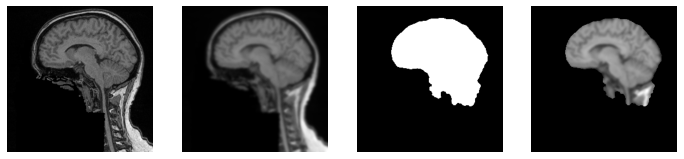

In [10]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(12, 4))
for i, img in enumerate([dir_img_ana,
                         dir_res_pro+"working_dir/smoothflow/smooth/sub-01_T1w_smooth.nii.gz",
                         dir_res_pro+"working_dir/smoothflow/skullstrip/sub-01_T1w_brain_mask.nii.gz",
                         dir_res_pro+"working_dir/smoothflow/mask/sub-01_T1w_smooth_masked.nii.gz"]):
    f.add_subplot(1, 4, i + 1)
    plot_slice(img)

# FIN